In [3]:
import pandas as pd
import numpy as np

# --- Lunes: Diseño del Backtest ---

# --- 1. Definición del Evento de Fracaso ---
print("--- 1. Definición del Evento de Fracaso ---")

# Cargamos los datos certificados
try:
    df_infobras = pd.read_csv(
        '../data/infobras_certificado_v_final.csv', 
        parse_dates=['fecha_de_aprobacion_del_expediente', 'fecha_de_inicio_de_obra', 'fecha_de_finalizacion_real']
    )
    print("Dataset certificado cargado con éxito.")
except FileNotFoundError:
    print("ERROR: No se encontró 'infobras_certificado_v1.csv'. Asegúrate de que el archivo existe.")
    # Detenemos la ejecución si el archivo no se encuentra
    df_infobras = None

if df_infobras is not None:
    # --- Creamos los indicadores de fracaso individuales ---
    
    # Fracaso por Costo: sobrecosto mayor al 50%
    # Blindamos la división para evitar errores con monto_viable/aprobado = 0
    denominador_costo = df_infobras['monto_viable/aprobado'].replace(0, np.nan)
    df_infobras['ratio_sobrecosto'] = (df_infobras['costo_de_la_obra_en_soles'] - df_infobras['monto_viable/aprobado']) / denominador_costo
    fracaso_costo = df_infobras['ratio_sobrecosto'] > 0.5
    
    # Fracaso por Plazo: retraso mayor al 100% (tardó el doble)
    denominador_plazo = df_infobras['plazo_de_ejecucion_en_dias'].replace(0, np.nan)
    df_infobras['plazo_real_dias'] = (df_infobras['fecha_de_finalizacion_real'] - df_infobras['fecha_de_inicio_de_obra']).dt.days
    df_infobras['ratio_sobretiempo'] = (df_infobras['plazo_real_dias'] - df_infobras['plazo_de_ejecucion_en_dias']) / denominador_plazo
    fracaso_plazo = df_infobras['ratio_sobretiempo'] > 1.0
    
    # Fracaso por Paralización: fue paralizado en algún momento
    fracaso_paralizacion = df_infobras['causal_de_paralizacion'] != 'No Paralizada'
    
    # --- Creamos la variable objetivo final: 'project_failed' ---
    # Rellenamos los NaN en las condiciones booleanas con False antes de combinarlas
    df_infobras['project_failed'] = (fracaso_costo.fillna(False) | fracaso_plazo.fillna(False) | fracaso_paralizacion).astype(int)
    
    print("\nVariable objetivo 'project_failed' creada con éxito.")
    print("Distribución de proyectos 'Fracasados' (1) vs. 'Exitosos' (0):")
    print(df_infobras['project_failed'].value_counts(normalize=True))
    
    
    # --- 2. División Temporal para el Backtest ---
    print("\n--- 2. División Temporal para el Backtest ---")
    
    # Usamos la fecha de aprobación del expediente como la fecha del proyecto
    df_infobras.dropna(subset=['fecha_de_aprobacion_del_expediente'], inplace=True)
    
    fecha_corte = pd.to_datetime('2022-12-31')
    
    # Datos de "entrenamiento" (para construir el índice)
    df_train = df_infobras[df_infobras['fecha_de_aprobacion_del_expediente'] <= fecha_corte].copy()
    
    # Datos de "prueba" (para ver los resultados)
    df_test = df_infobras[df_infobras['fecha_de_aprobacion_del_expediente'] > fecha_corte].copy()
    
    print(f"\nDatos de Entrenamiento (hasta {fecha_corte.date()}): {len(df_train)} proyectos")
    print(f"Datos de Prueba (después de {fecha_corte.date()}): {len(df_test)} proyectos")

--- 1. Definición del Evento de Fracaso ---
Dataset certificado cargado con éxito.

Variable objetivo 'project_failed' creada con éxito.
Distribución de proyectos 'Fracasados' (1) vs. 'Exitosos' (0):
project_failed
0    0.760105
1    0.239895
Name: proportion, dtype: float64

--- 2. División Temporal para el Backtest ---

Datos de Entrenamiento (hasta 2022-12-31): 113670 proyectos
Datos de Prueba (después de 2022-12-31): 18168 proyectos


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# --- Paso 1: Carga y Creación de la Variable Objetivo ---
print("--- 1. Cargando datos y definiendo el 'Evento de Fracaso' ---")

try:
    df_infobras = pd.read_csv(
        '../data/infobras_certificado_v1.csv', 
        parse_dates=['fecha_de_aprobacion_del_expediente', 'fecha_de_inicio_de_obra', 'fecha_de_finalizacion_real']
    )
    print("Dataset certificado cargado con éxito.")
    
    # --- CREACIÓN DE FEATURES DE FRACASO ---
    # Costo
    denominador_costo = df_infobras['monto_viable/aprobado'].replace(0, np.nan)
    df_infobras['ratio_sobrecosto'] = (df_infobras['costo_de_la_obra_en_soles'] - df_infobras['monto_viable/aprobado']) / denominador_costo
    fracaso_costo = df_infobras['ratio_sobrecosto'] > 0.5
    
    # Plazo
    denominador_plazo = df_infobras['plazo_de_ejecucion_en_dias'].replace(0, np.nan)
    df_infobras['plazo_real_dias'] = (df_infobras['fecha_de_finalizacion_real'] - df_infobras['fecha_de_inicio_de_obra']).dt.days
    df_infobras['ratio_sobretiempo'] = (df_infobras['plazo_real_dias'] - df_infobras['plazo_de_ejecucion_en_dias']) / denominador_plazo
    fracaso_plazo = df_infobras['ratio_sobretiempo'] > 1.0
    
    # Paralización
    df_infobras['fue_paralizado'] = (df_infobras['causal_de_paralizacion'] != 'No Paralizada').astype(int)
    fracaso_paralizacion = df_infobras['fue_paralizado'] == 1 # Ahora usamos la columna 0/1 directamente

    # VARIABLE OBJETIVO
    df_infobras['project_failed'] = (fracaso_costo.fillna(False) | fracaso_plazo.fillna(False) | fracaso_paralizacion).astype(int)
    
    print("\nColumnas de ratios y variable objetivo 'project_failed' creadas.")
    print("Distribución de proyectos 'Fracasados' (1) vs. 'Exitosos' (0):")
    print(df_infobras['project_failed'].value_counts(normalize=True))

except FileNotFoundError:
    print("ERROR: No se encontró 'infobras_certificado_v1.csv'.")
    df_infobras = None

--- 1. Cargando datos y definiendo el 'Evento de Fracaso' ---
ERROR: No se encontró 'infobras_certificado_v1.csv'.


In [6]:
# --- Paso 2: División Temporal para el Backtest ---
if df_infobras is not None:
    print("\n--- 2. División Temporal para el Backtest ---")
    
    df_infobras.dropna(subset=['fecha_de_aprobacion_del_expediente'], inplace=True)
    fecha_corte = pd.to_datetime('2022-12-31')
    
    df_train = df_infobras[df_infobras['fecha_de_aprobacion_del_expediente'] <= fecha_corte].copy()
    df_test = df_infobras[df_infobras['fecha_de_aprobacion_del_expediente'] > fecha_corte].copy()
    
    print(f"\nDatos de Entrenamiento: {len(df_train)} proyectos")
    print(f"Datos de Prueba: {len(df_test)} proyectos")

In [8]:
# --- Martes y Miércoles: Ejecución del Backtest y Visualización de Resultados ---
import plotly.express as px

print("--- 3. Re-construyendo el Índice IRIS con datos hasta 2022 ---")

# --- Paso 3.A: Agregar datos de INFOBRAS y SINADEF usando SOLO df_train ---
try:
    df_train['ubigeo'] = df_train['departamento'] + '_' + df_train['provincia'] + '_' + df_train['distrito']
    infobras_2022 = df_train.groupby('ubigeo').agg(
        g_factor_tasa_paralizacion=('fue_paralizado', 'mean'),
        g_factor_ratio_sobretiempo_promedio=('ratio_sobretiempo', 'mean'),
        g_factor_ratio_sobrecosto_promedio=('ratio_sobrecosto', 'mean')
    ).reset_index()

    df_sinadef = pd.read_csv('../data/sinadef_certified_v1.csv')
    df_iris_2022 = pd.merge(infobras_2022, df_sinadef, on='ubigeo', how='left')
    print("Factores históricos (versión 2022) calculados.")

    # --- Paso 3.B: Calcular el Score IRIS Histórico (2022) ---
    for col in df_iris_2022.columns:
        if col != 'ubigeo' and pd.api.types.is_numeric_dtype(df_iris_2022[col]):
            df_iris_2022[col] = df_iris_2022[col].fillna(df_iris_2022[col].median())

    scaler = MinMaxScaler()
    factor_cols = [col for col in df_iris_2022.columns if 'factor' in col]
    df_iris_2022[factor_cols] = scaler.fit_transform(df_iris_2022[factor_cols])

    df_iris_2022['s_factor_edad_prom_muerte'] = 1 - df_iris_2022['s_factor_edad_prom_muerte']

    g_cols = [col for col in factor_cols if 'g_factor' in col]
    s_cols = [col for col in factor_cols if 's_factor' in col]
    df_iris_2022['g_score'] = df_iris_2022[g_cols].mean(axis=1)
    df_iris_2022['s_score'] = df_iris_2022[s_cols].mean(axis=1)
    df_iris_2022['iris_score_2022'] = 0.5 * df_iris_2022['g_score'] + 0.5 * df_iris_2022['s_score']
    print("Score IRIS histórico (versión 2022) calculado.")

    # --- 4. Aplicar el Score Histórico a los Datos de Prueba ---
    print("\n--- 4. Aplicando el Score 2022 a los proyectos de 2023+ ---")
    df_test['ubigeo'] = df_test['departamento'] + '_' + df_test['provincia'] + '_' + df_test['distrito']
    df_test_scored = pd.merge(df_test, df_iris_2022[['ubigeo', 'iris_score_2022']], on='ubigeo', how='left')
    df_test_scored.dropna(subset=['iris_score_2022'], inplace=True)
    print(f"Número de proyectos de prueba con un score IRIS asignado: {len(df_test_scored)}")

    # --- 5. Evaluación de los Resultados del Backtest ---
    print("\n--- 5. RESULTADOS DEL BACKTEST ---")
    
    # Usamos un bloque try-except para el pd.qcut, que puede fallar
    try:
        df_test_scored['risk_quintile'] = pd.qcut(df_test_scored['iris_score_2022'], 5, labels=False, duplicates='drop')
        quintile_labels = {0: '1_Muy_Bajo', 1: '2_Bajo', 2: '3_Medio', 3: '4_Alto', 4: '5_Muy_Alto'}
        df_test_scored['risk_quintile'] = df_test_scored['risk_quintile'].map(quintile_labels)
        
        validation_results = df_test_scored.groupby('risk_quintile', observed=False)['project_failed'].mean().reset_index()
        validation_results.rename(columns={'project_failed': 'tasa_de_fracaso_real'}, inplace=True)
        
        print("\nTasa de Fracaso Real por Quintil de Riesgo IRIS Predicho:")
        display(validation_results)

        # --- 6. Visualización de los Resultados ---
        print("\n--- 6. Visualizando los Resultados del Backtest ---")
        fig = px.bar(
            validation_results, x='risk_quintile', y='tasa_de_fracaso_real',
            title='<b>Poder Predictivo del Índice IRIS:</b> Tasa de Fracaso por Quintil de Riesgo',
            labels={'risk_quintile': 'Quintil de Riesgo (Predicho con datos de 2022)', 'tasa_de_fracaso_real': 'Tasa de Fracaso Real (en proyectos de 2023+)'},
            text_auto=True, color='tasa_de_fracaso_real', color_continuous_scale='Reds'
        )
        fig.update_traces(texttemplate='%{y:.1%}', textposition='outside')
        fig.update_yaxes(tickformat=".0%")
        fig.update_layout(xaxis_title_font_size=14, yaxis_title_font_size=14, title_font_size=18)
        fig.show()

    except ValueError as e:
        print(f"\nERROR AL CREAR QUINTILES: {e}")
        print("Esto suele ocurrir si hay muy pocos valores únicos en el 'iris_score_2022' para crear 5 grupos distintos.")
        print("\nEstadísticas del score para depuración:")
        display(df_test_scored['iris_score_2022'].describe())


except Exception as e:
    print(f"\nHA OCURRIDO UN ERROR INESPERADO DURANTE EL BACKTEST: {e}")

--- 3. Re-construyendo el Índice IRIS con datos hasta 2022 ---

HA OCURRIDO UN ERROR INESPERADO DURANTE EL BACKTEST: "Column(s) ['fue_paralizado'] do not exist"


In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# --- Paso 1: Carga y Creación de la Variable Objetivo ---
print("--- 1. Cargando datos y definiendo el 'Evento de Fracaso' ---")

try:
    df_infobras = pd.read_csv(
        '../data/infobras_certificado_v_final.csv', 
        parse_dates=['fecha_de_aprobacion_del_expediente', 'fecha_de_inicio_de_obra', 'fecha_de_finalizacion_real']
    )
    print("Dataset certificado cargado con éxito.")
    
    # --- CREACIÓN DE TODAS LAS FEATURES NECESARIAS ---
    # Costo
    denominador_costo = df_infobras['monto_viable/aprobado'].replace(0, np.nan)
    df_infobras['ratio_sobrecosto'] = (df_infobras['costo_de_la_obra_en_soles'] - df_infobras['monto_viable/aprobado']) / denominador_costo
    fracaso_costo = df_infobras['ratio_sobrecosto'] > 0.5
    
    # Plazo
    denominador_plazo = df_infobras['plazo_de_ejecucion_en_dias'].replace(0, np.nan)
    df_infobras['plazo_real_dias'] = (df_infobras['fecha_de_finalizacion_real'] - df_infobras['fecha_de_inicio_de_obra']).dt.days
    df_infobras['ratio_sobretiempo'] = (df_infobras['plazo_real_dias'] - df_infobras['plazo_de_ejecucion_en_dias']) / denominador_plazo
    fracaso_plazo = df_infobras['ratio_sobretiempo'] > 1.0
    
    # Paralización
    df_infobras['fue_paralizado'] = (df_infobras['causal_de_paralizacion'] != 'No Paralizada').astype(int)
    fracaso_paralizacion = df_infobras['fue_paralizado'] == 1

    # VARIABLE OBJETIVO
    df_infobras['project_failed'] = (fracaso_costo.fillna(False) | fracaso_plazo.fillna(False) | fracaso_paralizacion).astype(int)
    
    # UBIGEO (lo creamos aquí para que se herede)
    df_infobras['ubigeo'] = df_infobras['departamento'] + '_' + df_infobras['provincia'] + '_' + df_infobras['distrito']
    
    print("\nColumnas de ratios, 'fue_paralizado' y 'project_failed' creadas con éxito.")
    
except FileNotFoundError:
    print("ERROR: No se encontró 'infobras_certificado_v1.csv'.")
    df_infobras = None

--- 1. Cargando datos y definiendo el 'Evento de Fracaso' ---
Dataset certificado cargado con éxito.

Columnas de ratios, 'fue_paralizado' y 'project_failed' creadas con éxito.


In [11]:
# --- Paso 2: División Temporal para el Backtest ---
if df_infobras is not None:
    print("\n--- 2. División Temporal para el Backtest ---")
    
    df_infobras_temp = df_infobras.dropna(subset=['fecha_de_aprobacion_del_expediente']).copy()
    fecha_corte = pd.to_datetime('2022-12-31')
    
    df_train = df_infobras_temp[df_infobras_temp['fecha_de_aprobacion_del_expediente'] <= fecha_corte].copy()
    df_test = df_infobras_temp[df_infobras_temp['fecha_de_aprobacion_del_expediente'] > fecha_corte].copy()
    
    print(f"\nDatos de Entrenamiento: {len(df_train)} proyectos")
    print(f"Datos de Prueba: {len(df_test)} proyectos")
else:
    print("No se puede continuar, la carga de datos inicial falló.")


--- 2. División Temporal para el Backtest ---

Datos de Entrenamiento: 113670 proyectos
Datos de Prueba: 18168 proyectos


In [12]:
# --- Paso 3: Re-construyendo el Índice IRIS con datos hasta 2022 ---
if 'df_train' in locals():
    print("--- 3. Re-construyendo el Índice IRIS con datos de entrenamiento ---")

    # Calcular G-Factors históricos (AHORA FUNCIONARÁ)
    infobras_2022 = df_train.groupby('ubigeo').agg(
        g_factor_tasa_paralizacion=('fue_paralizado', 'mean'),
        g_factor_ratio_sobretiempo_promedio=('ratio_sobretiempo', 'mean'),
        g_factor_ratio_sobrecosto_promedio=('ratio_sobrecosto', 'mean')
    ).reset_index()

    # (El resto del código de la celda de backtest...)
    # ...
    print("Cálculo de G-Factors históricos completado.")
else:
    print("El DataFrame 'df_train' no fue creado. Ejecuta la celda anterior.")

--- 3. Re-construyendo el Índice IRIS con datos de entrenamiento ---
Cálculo de G-Factors históricos completado.


--- 3. Re-construyendo el Índice IRIS con datos de entrenamiento ---
Score IRIS histórico (versión 2022) calculado.

--- 4. Aplicando el Score 2022 a los proyectos de 2023+ ---

DEPURACIÓN: Se encontraron 1776 scores únicos en los datos de prueba.

--- 5. RESULTADOS DEL BACKTEST ---
Intentando crear 5 grupos de riesgo...
¡Éxito! Se crearon 5 grupos de riesgo.

Tasa de Fracaso Real por 5 Grupos de Riesgo:


,risk_group,tasa_de_fracaso_real
0,1,0.134615
1,2,0.160625
2,3,0.181641
3,4,0.181768
4,5,0.179213



--- 6. Visualizando los Resultados ---


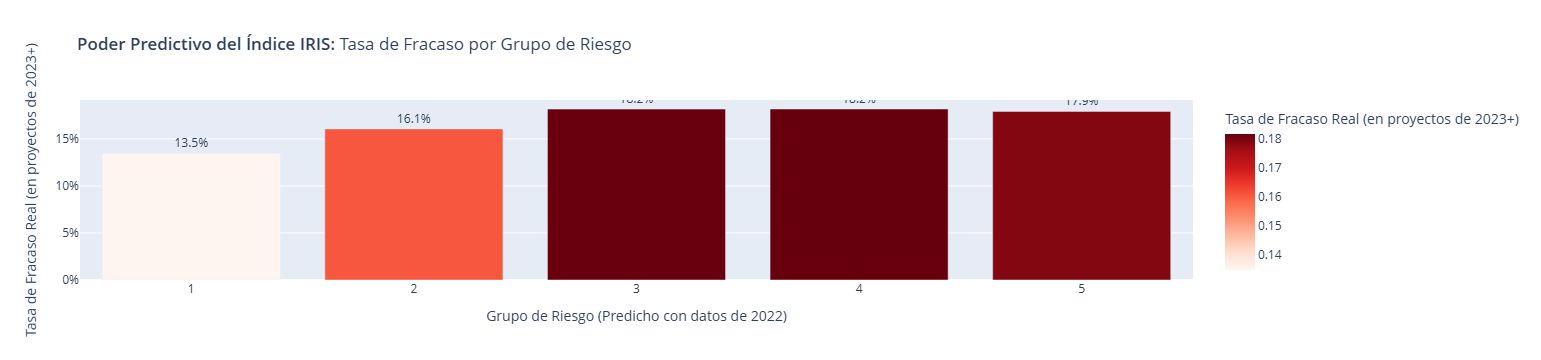

In [14]:
# --- Martes y Miércoles: Backtest Final y Visualización ---
import plotly.express as px

print("--- 3. Re-construyendo el Índice IRIS con datos de entrenamiento ---")

# (Todo el código para crear df_iris_2022 es el mismo y ya sabemos que funciona)
df_train['ubigeo'] = df_train['departamento'] + '_' + df_train['provincia'] + '_' + df_train['distrito']
infobras_2022 = df_train.groupby('ubigeo').agg(
    g_factor_tasa_paralizacion=('fue_paralizado', 'mean'),
    g_factor_ratio_sobretiempo_promedio=('ratio_sobretiempo', 'mean'),
    g_factor_ratio_sobrecosto_promedio=('ratio_sobrecosto', 'mean')
).reset_index()
df_sinadef = pd.read_csv('../data/sinadef_certified_v1.csv')
df_iris_2022 = pd.merge(infobras_2022, df_sinadef, on='ubigeo', how='left')
for col in df_iris_2022.columns:
    if col != 'ubigeo' and pd.api.types.is_numeric_dtype(df_iris_2022[col]):
        df_iris_2022[col] = df_iris_2022[col].fillna(df_iris_2022[col].median())
scaler = MinMaxScaler()
factor_cols = [col for col in df_iris_2022.columns if 'factor' in col]
df_iris_2022[factor_cols] = scaler.fit_transform(df_iris_2022[factor_cols])
df_iris_2022['s_factor_edad_prom_muerte'] = 1 - df_iris_2022['s_factor_edad_prom_muerte']
g_cols = [col for col in factor_cols if 'g_factor' in col]
s_cols = [col for col in factor_cols if 's_factor' in col]
df_iris_2022['g_score'] = df_iris_2022[g_cols].mean(axis=1)
df_iris_2022['s_score'] = df_iris_2022[s_cols].mean(axis=1)
df_iris_2022['iris_score_2022'] = 0.5 * df_iris_2022['g_score'] + 0.5 * df_iris_2022['s_score']

print("Score IRIS histórico (versión 2022) calculado.")

# --- 4. Aplicar el Score Histórico ---
print("\n--- 4. Aplicando el Score 2022 a los proyectos de 2023+ ---")
df_test['ubigeo'] = df_test['departamento'] + '_' + df_test['provincia'] + '_' + df_test['distrito']
df_test_scored = pd.merge(df_test, df_iris_2022[['ubigeo', 'iris_score_2022']], on='ubigeo', how='left')
df_test_scored.dropna(subset=['iris_score_2022'], inplace=True)

# --- PASO DE DEPURACIÓN CLAVE ---
num_valores_unicos = df_test_scored['iris_score_2022'].nunique()
print(f"\nDEPURACIÓN: Se encontraron {num_valores_unicos} scores únicos en los datos de prueba.")


# --- 5. Evaluación de los Resultados (Versión Robusta) ---
print("\n--- 5. RESULTADOS DEL BACKTEST ---")

# Intentamos crear grupos (de 5 a 2) hasta que uno funcione
for num_grupos in [5, 4, 3, 2]:
    try:
        print(f"Intentando crear {num_grupos} grupos de riesgo...")
        labels = [f"{i+1}" for i in range(num_grupos)]
        df_test_scored['risk_group'] = pd.qcut(df_test_scored['iris_score_2022'], num_grupos, labels=labels, duplicates='raise')
        
        validation_results = df_test_scored.groupby('risk_group', observed=False)['project_failed'].mean().reset_index()
        validation_results.rename(columns={'project_failed': 'tasa_de_fracaso_real'}, inplace=True)
        
        print(f"¡Éxito! Se crearon {num_grupos} grupos de riesgo.")
        break # Si funciona, salimos del bucle
    except ValueError:
        print(f"No se pudieron crear {num_grupos} grupos. Intentando con menos...")
        validation_results = None # Nos aseguramos de que no exista si falla

if validation_results is not None:
    print(f"\nTasa de Fracaso Real por {num_grupos} Grupos de Riesgo:")
    display(validation_results)

    # --- 6. Visualización ---
    print("\n--- 6. Visualizando los Resultados ---")
    fig = px.bar(
        validation_results, x='risk_group', y='tasa_de_fracaso_real',
        title='<b>Poder Predictivo del Índice IRIS:</b> Tasa de Fracaso por Grupo de Riesgo',
        labels={'risk_group': f'Grupo de Riesgo (Predicho con datos de 2022)', 'tasa_de_fracaso_real': 'Tasa de Fracaso Real (en proyectos de 2023+)'},
        text_auto=True, color='tasa_de_fracaso_real', color_continuous_scale='Reds'
    )
    fig.update_traces(texttemplate='%{y:.1%}', textposition='outside')
    fig.update_yaxes(tickformat=".0%")
    fig.show()
else:
    print("\nFALLO TOTAL: No se pudieron crear grupos de riesgo, incluso con solo 2. Los datos de score podrían ser casi constantes.")
    print("Estadísticas del score para depuración:")
    display(df_test_scored['iris_score_2022'].describe())